# Testing the OPTAA EA/CG Processing Code

Updated code for processing the parsed OPTAA data from the Endurance Array (EA) and the Coastal and Global (CG) Pioneer and Global arrays.

* Creates a coordinate variable, `wavelength_number`. The is an integer array from 0 to 99, and it serves as a dimension for the 2D absorption and attenuation arrays. These arrays would normally be ragged (length differs between low 70's and low 90's for different OPTAAS). The use of this dimensional variable, with all arrays padded with fill values to a common length, will correct storage errors in ERDDAP.
* Add the processed variables (filled with either a NaN or -9999999) prior to any other processing. If no calibration data is available, the dataset is saved as-is with a `processing_level` global attribute set to `parsed` to indicate the absence of processed data. Otherwise, the `processing_level` is `processed`.
* Adds a method to burst average the data set, helping to reduce point-to-point variability within the burst as well as reduce the size of the data set. The OPTAA data is sampled in a burst at ~4 Hz for up to 4 minutes every hour. Taken together, the bursts quickly add up in size making working with even a weeks worth of data difficult. Averaging the bursts also helps address some of the inherent issues in the OPTAA array data with a mid-spectra discontinuity that has never been corrected by the vendor.
* Adds calculations to estimate the concentrations of chlorophyll and particulate organic carbon (POC).
* Adds calculations to estimate absorption ratios of four different wavelengths as a function of aborption at 440 nm.

In [1]:
# import environment level modules
import os
import xarray as xr

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

# import the processing module under review
from cgsn_processing.process.proc_optaa import proc_optaa

## Load and review data from CE04OSSM-00010 deployed July 12, 2020

In [2]:
# setup base data directory
home = os.path.expanduser('~')
test_base = os.path.abspath(os.path.join(home, 'ooidata/testing/ce04ossm/optaa'))

# setup inputs needed by the function
infile = os.path.join(test_base, '20200801_003021.optaa.json')
coeff_file = os.path.join(test_base, 'optaa.cal_coeffs.json')
platform = 'CE04OSSM'  # platform name, upper case
deployment = 'D00010'  # deployment name, upper case
lat = 44.37868         # deployment latitude, from anchor survey
lon = -124.94508       # deployment longitude, from anchor survey
depth = 7.0            # NSIF depth
ctd_name = 'ctdbp'     # directory name of co-located CTD

### Load and display the data without burst averaging

In [3]:
# process the data file -- burst averaging is set to false
burst = False
optaa = proc_optaa(infile, coeff_file, platform, deployment, lat, lon, depth, ctd_name, False)
optaa

<xarray.Dataset>
Dimensions:                (station: 1, time: 679, wavelength_number: 100)
Coordinates:
  * time                   (time) float64 1.596e+09 1.596e+09 ... 1.596e+09
  * wavelength_number      (wavelength_number) int32 0 1 2 3 4 ... 96 97 98 99
  * station                (station) <U8 'CE04OSSM'
Data variables:
    z                      (station, time) float64 7.0 7.0 7.0 ... 7.0 7.0 7.0
    serial_number          (station, time) int32 208 208 208 208 ... 208 208 208
    elapsed_run_time       (station, time) float64 6.018e+04 ... 2.302e+05
    internal_temp_raw      (station, time) int32 49491 49489 ... 49497 49498
    external_temp_raw      (station, time) int32 37549 37550 ... 37606 37600
    pressure_raw           (station, time) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    a_signal_dark          (station, time) int32 700 700 700 700 ... 700 700 700
    a_reference_dark       (station, time) int32 472 472 471 472 ... 470 470 470
    c_signal_dark          (station, time) int32 710 710 711 711 ... 709 709 709
    c_reference_dark       (station, time) int32 476 476 477 477 ... 474 475 474
    internal_temp          (station, time) float64 13.06 13.06 ... 13.04 13.04
    external_temp          (station, time) float64 12.9 12.89 ... 12.81 12.82
    pressure               (station, time) float64 nan nan nan ... nan nan nan
    estimated_chlorophyll  (station, time) float64 1.566 1.684 ... 1.567 1.571
    estimated_poc          (station, time) float64 303.3 315.3 ... 288.8 289.5
    ratio_cdom             (station, time) float64 1.293 1.219 ... 1.261 1.225
    ratio_carotenoids      (station, time) float64 0.6011 0.5823 ... 0.5837
    ratio_phycobilins      (station, time) float64 0.3663 0.3522 ... 0.3621
    ratio_qband            (station, time) float64 0.1979 0.2042 ... 0.1918
    ctd_temperature        (station, time) float64 13.05 13.05 ... 13.05 13.05
    ctd_salinity           (station, time) float64 32.46 32.46 ... 32.46 32.46
    a_wavelengths          (station, time, wavelength_number) float64 401.2 ....
    a_signal_raw           (station, time, wavelength_number) int32 398 ... -...
    a_reference_raw        (station, time, wavelength_number) int32 745 ... -...
    c_wavelengths          (station, time, wavelength_number) float64 400.0 ....
    c_signal_raw           (station, time, wavelength_number) int32 648 ... -...
    c_reference_raw        (station, time, wavelength_number) int32 700 ... -...
    apd                    (station, time, wavelength_number) float64 0.43 .....
    apd_ts                 (station, time, wavelength_number) float64 0.4296 ...
    apd_ts_s               (station, time, wavelength_number) float64 0.3834 ...
    cpd                    (station, time, wavelength_number) float64 1.193 ....
    cpd_ts                 (station, time, wavelength_number) float64 1.194 ....
    deploy_id              (station, time) <U6 'D00010' 'D00010' ... 'D00010'
    lat                    (station) float64 44.38
    lon                    (station) float64 -124.9
Attributes:
    title:                         Optical Absorbance and Attenuation from OPTAA
    summary:                       Measures the absorabance and attenuation o...
    project:                       Ocean Observatories Initiative
    institution:                   Coastal and Global Scale Nodes, (CGSN)
    acknowledgement:               National Science Foundation
    references:                    http://oceanobservatories.org
    creator_name:                  Ocean Observatories Initiative
    creator_email:                 helpdesk@oceanobservatories.org
    creator_url:                   http://oceanobservatories.org
    featureType:                   timeSeries
    cdm_data_type:                 Station
    Conventions:                   CF-1.6
    comment:                       Mooring ID: CE04OSSM-00010
    date_created:                  2021-01-06T19:02:00Z
    geospatial_lat_max:            44.37868
    geospatial

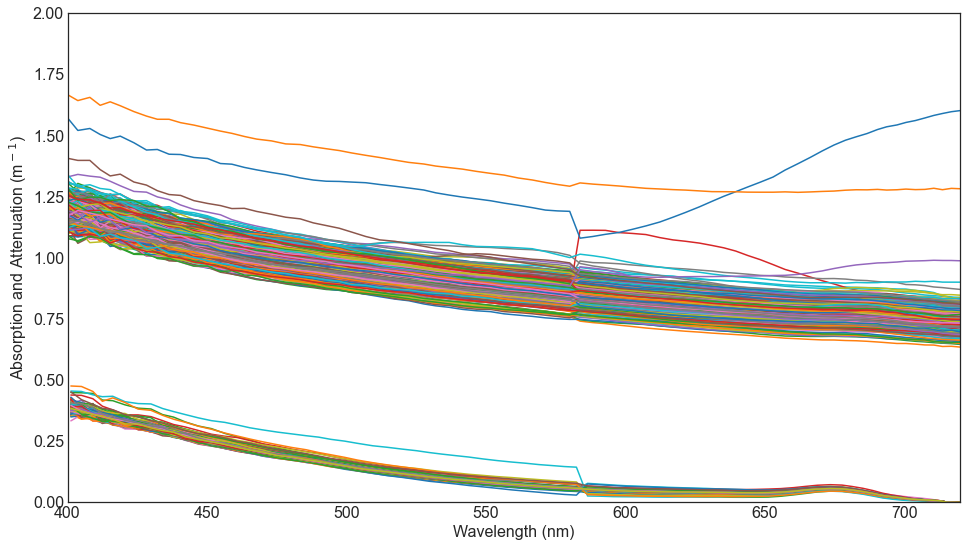

In [4]:
# plot the absorption and attenuation spectra
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16})
plt.plot(optaa.a_wavelengths[0, :, :].T, optaa.apd_ts_s[0, :, :].T, label='apd')
plt.plot(optaa.c_wavelengths[0, :, :].T, optaa.cpd_ts[0, :, :].T, label='cpd')
plt.ylabel('Absorption and Attenuation (m$^-$$^1$)')
plt.xlabel('Wavelength (nm)')
plt.xlim(400, 720)
plt.ylim(0, 2)
plt.show()

Data from the burst collected on 2020-08-01 at 00:30:21 UTC. Notice overall point-to-point consistency in the spectra as well as the spectral discontinuity at ~580 nm. This "break" is very common in the OPTAA data and is believed to be an artifact of onboard processing. 

### Load and display the data with burst averaging

In [5]:
# process the data file -- burst averaging set to true
burst = True
burst = proc_optaa(infile, coeff_file, platform, deployment, lat, lon, depth, ctd_name, burst)
burst

<xarray.Dataset>
Dimensions:                (station: 1, time: 1, wavelength_number: 100)
Coordinates:
  * time                   (time) float64 1.596e+09
  * wavelength_number      (wavelength_number) int32 0 1 2 3 4 ... 96 97 98 99
  * station                (station) <U8 'CE04OSSM'
Data variables:
    z                      (station, time) float64 7.0
    serial_number          (station, time) float64 208.0
    elapsed_run_time       (station, time) float64 1.452e+05
    internal_temp_raw      (station, time) float64 4.949e+04
    external_temp_raw      (station, time) float64 3.756e+04
    pressure_raw           (station, time) float64 0.0
    a_signal_dark          (station, time) float64 699.0
    a_reference_dark       (station, time) float64 471.0
    c_signal_dark          (station, time) float64 710.0
    c_reference_dark       (station, time) float64 475.0
    internal_temp          (station, time) float64 13.06
    external_temp          (station, time) float64 12.87
    pressure               (station, time) float64 nan
    estimated_chlorophyll  (station, time) float64 1.607
    estimated_poc          (station, time) float64 300.0
    ratio_cdom             (station, time) float64 1.252
    ratio_carotenoids      (station, time) float64 0.5946
    ratio_phycobilins      (station, time) float64 0.3636
    ratio_qband            (station, time) float64 0.1959
    ctd_temperature        (station, time) float64 13.05
    ctd_salinity           (station, time) float64 32.46
    a_wavelengths          (station, time, wavelength_number) float64 401.2 ....
    a_signal_raw           (station, time, wavelength_number) float64 nan ......
    a_reference_raw        (station, time, wavelength_number) float64 nan ......
    c_wavelengths          (station, time, wavelength_number) float64 400.0 ....
    c_signal_raw           (station, time, wavelength_number) float64 nan ......
    c_reference_raw        (station, time, wavelength_number) float64 nan ......
    apd                    (station, time, wavelength_number) float64 0.4367 ...
    apd_ts                 (station, time, wavelength_number) float64 0.4363 ...
    apd_ts_s               (station, time, wavelength_number) float64 0.3877 ...
    cpd                    (station, time, wavelength_number) float64 1.199 ....
    cpd_ts                 (station, time, wavelength_number) float64 1.2 ......
    deploy_id              (station, time) <U6 'D00010'
    lat                    (station) float64 44.38
    lon                    (station) float64 -124.9
Attributes:
    title:                         Optical Absorbance and Attenuation from OPTAA
    summary:                       Measures the absorabance and attenuation o...
    project:                       Ocean Observatories Initiative
    institution:                   Coastal and Global Scale Nodes, (CGSN)
    acknowledgement:               National Science Foundation
    references:                    http://oceanobservatories.org
    creator_name:                  Ocean Observatories Initiative
    creator_email:                 helpdesk@oceanobservatories.org
    creator_url:                   http://oceanobservatories.org
    featureType:                   timeSeries
    cdm_data_type:                 Station
    Conventions:                   CF-1.6
    comment:                       Mooring ID: CE04OSSM-00010
    date_created:                  2021-01-06T19:03:00Z
    geospatial_lat_max:            44.37868
    geospatial_lat_min:            44.37868
    geospatial_lon_max:            -124.94508
    geospatial_lon_min:            -124.94508
    geospatial_vertical_max:       7.0
    geospatial_vertical_min:       7.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    processing_level:              processed

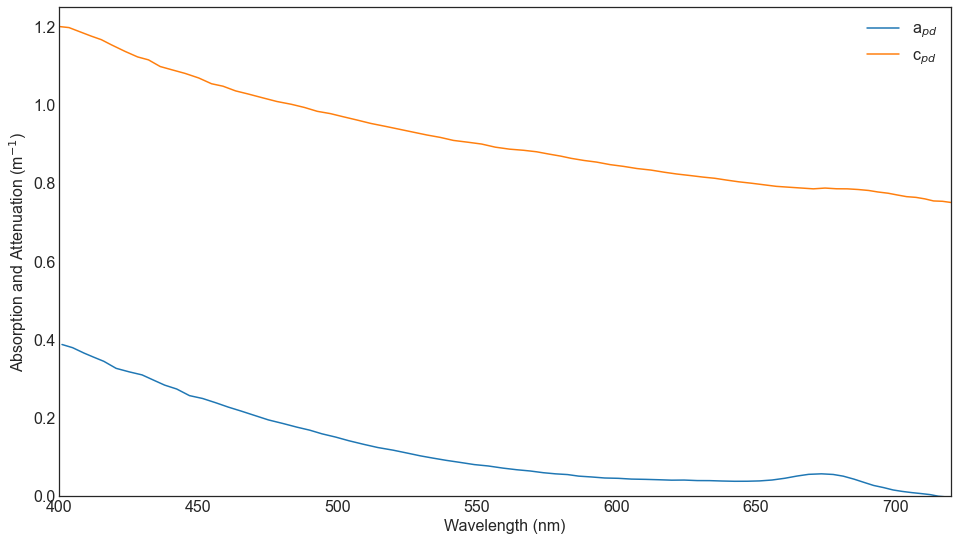

In [6]:
# plot the absorption and attenuation spectra
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16})
plt.plot(burst.a_wavelengths[0, :, :].T, burst.apd_ts_s[0, :, :].T, label='a$_{pd}$')
plt.plot(burst.c_wavelengths[0, :, :].T, burst.cpd_ts[0, :, :].T, label='c$_{pd}$')
plt.ylabel('Absorption and Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.xlim(400, 720)
plt.ylim(0, 1.25)
plt.legend()
plt.show()

The same set of spectra as above, this time median averaged to create cleaner spectra with the overall shapes much easier to discern.

### Load and display data collected through September 21, 2020 with burst averaging applied

In [7]:
# load and process all the data from July 12 through September 21, 2020, using burst averaging
files = [x for x in os.listdir(test_base) if x.endswith("optaa.json")]
data = []
for file in files:
    infile = os.path.join(test_base, file)
    d = proc_optaa(infile, coeff_file, platform, deployment, lat, lon, depth, burst=True, ctd_name=ctd_name)
    data.append(d)
    
# compile all the processed data into a singe dataset
ce04 = xr.concat(data, dim='time')
ce04 = ce04.sortby('time')
ce04 = xr.decode_cf(ce04)

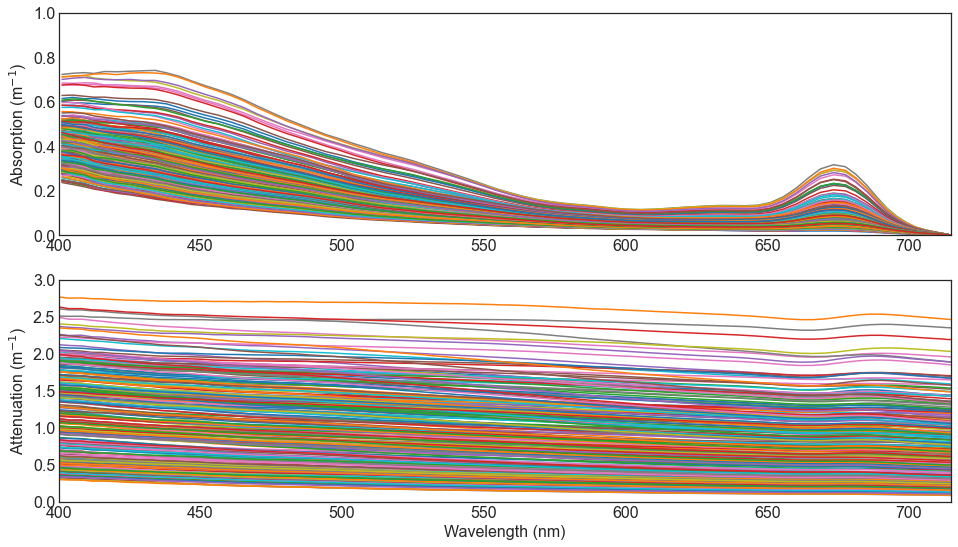

In [8]:
# plot the absorption and attenuation spectra
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16})
plt.subplot(2,1,1)
plt.plot(ce04.a_wavelengths[0, :, :].T, ce04.apd_ts_s[0, :, :].T, label='a$_{pd}$')
plt.ylabel('Absorption (m$^{-1}$)')
plt.ylim(0, 1)
plt.xlim(400, 715)
plt.subplot(2,1,2)
plt.plot(ce04.c_wavelengths[0, :, :].T, ce04.cpd_ts[0, :, :].T, label='c$_{pd}$')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.ylim(0, 3)
plt.xlim(400, 715)
plt.show()

Notice the overall shape of the spectra collect at CE04OSSM over 2 months. Spectra impacted by biofouling would not be expected to look this clean, textbook almost.

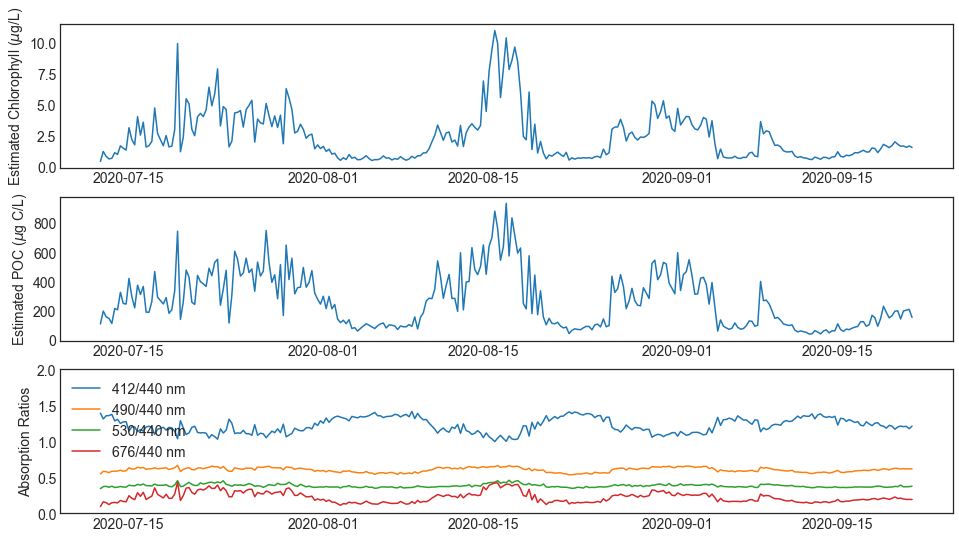

In [9]:
# plot a timeseries of the derived variables
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.subplot(3,1,1)
plt.plot(ce04.time, ce04.estimated_chlorophyll[0, :], label='chl')
plt.ylabel('Estimated Chlorophyll ($\mu$g/L)')
plt.subplot(3,1,2)
plt.plot(ce04.time, ce04.estimated_poc[0, :], label='poc')
plt.ylabel('Estimated POC ($\mu$g C/L)')
plt.subplot(3,1,3)
plt.plot(ce04.time, ce04.ratio_cdom[0, :], label='412/440 nm')
plt.plot(ce04.time, ce04.ratio_carotenoids[0, :], label='490/440 nm')
plt.plot(ce04.time, ce04.ratio_phycobilins[0, :], label='530/440 nm')
plt.plot(ce04.time, ce04.ratio_qband[0, :], label='676/440 nm')
plt.ylim(0, 2)
plt.ylabel('Absorption Ratios')
plt.legend(facecolor="white")
plt.show()

### Load and display data collected at CE07SHSM through September 21, 2020 with burst averaging applied

In [10]:
# load and process all the data from July 4 through September 21, 2020
test_base = os.path.abspath(os.path.join(home, 'ooidata/testing/ce07shsm/optaa1'))
coeff_file = os.path.join(test_base, 'optaa.cal_coeffs.json')
files = [x for x in os.listdir(test_base) if x.endswith("optaa1.json")]
data = []
for file in files:
    infile = os.path.join(test_base, file)
    d = proc_optaa(infile, coeff_file, platform, deployment, lat, lon, depth, burst=True, ctd_name='ctdbp1')
    data.append(d)

# compile all the processed data into a singe dataset
ce07 = xr.concat(data, dim='time')
ce07 = ce07.sortby('time')
ce07 = xr.decode_cf(ce07)

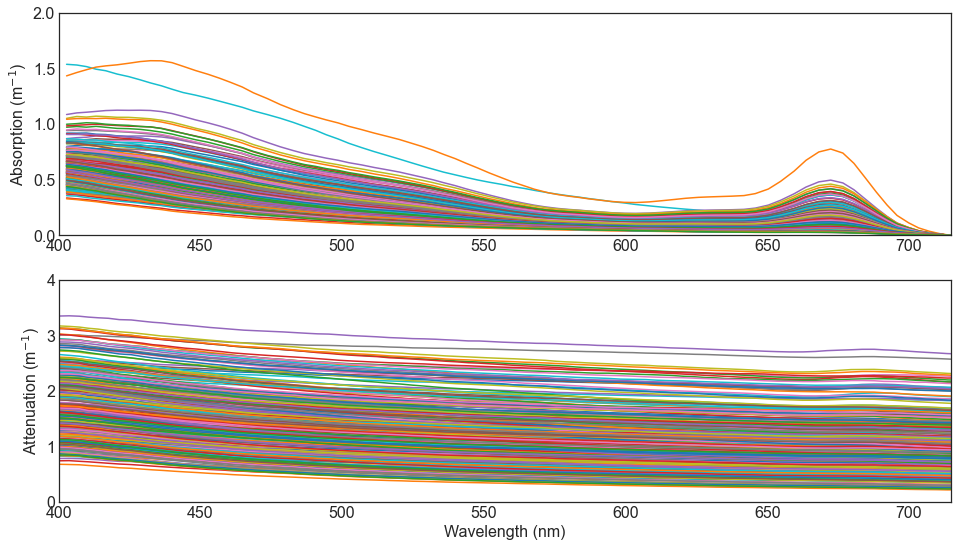

In [11]:
# plot the absorption and attenuation spectra
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16})
plt.subplot(2,1,1)
plt.plot(ce07.a_wavelengths[0, :, :].T, ce07.apd_ts_s[0, :, :].T, label='a$_{pd}$')
plt.ylabel('Absorption (m$^{-1}$)')
plt.ylim(0, 2)
plt.xlim(400, 715)
plt.subplot(2,1,2)
plt.plot(ce07.c_wavelengths[0, :, :].T, ce07.cpd_ts[0, :, :].T, label='c$_{pd}$')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.ylim(0, 4)
plt.xlim(400, 715)
plt.show()

Comparable spectra to the data collected at CE04OSSM, though slightly higher. Clean and consistent.

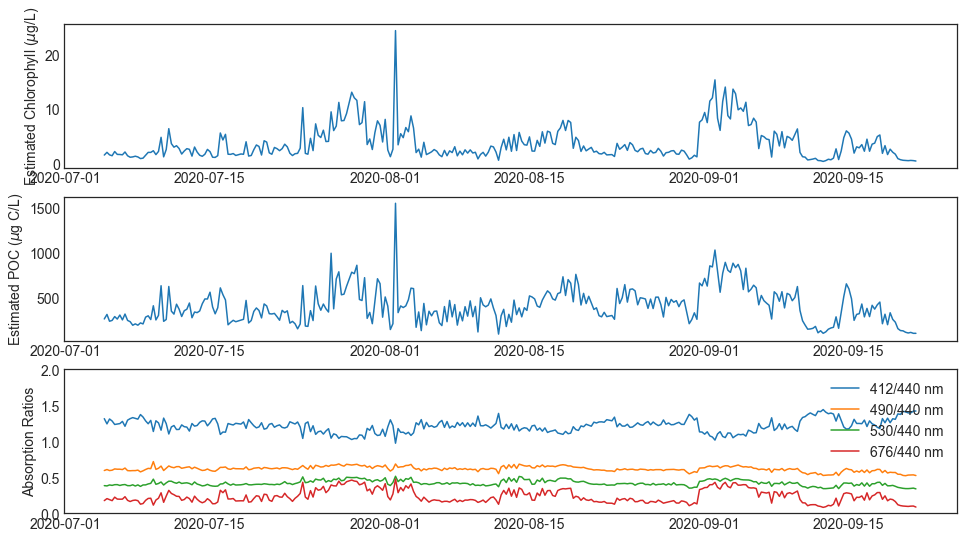

In [12]:
# plot concentrations and ratios
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.subplot(3,1,1)
plt.plot(ce07.time, ce07.estimated_chlorophyll[0, :], label='chl')
plt.ylabel('Estimated Chlorophyll ($\mu$g/L)')
plt.subplot(3,1,2)
plt.plot(ce07.time, ce07.estimated_poc[0, :], label='poc')
plt.ylabel('Estimated POC ($\mu$g C/L)')
plt.subplot(3,1,3)
plt.plot(ce07.time, ce07.ratio_cdom[0, :], label='412/440 nm')
plt.plot(ce07.time, ce07.ratio_carotenoids[0, :], label='490/440 nm')
plt.plot(ce07.time, ce07.ratio_phycobilins[0, :], label='530/440 nm')
plt.plot(ce07.time, ce07.ratio_qband[0, :], label='676/440 nm')
plt.ylim(0, 2)
plt.ylabel('Absorption Ratios')
plt.legend(facecolor="white")
plt.show()